In [1]:
import torch #main frame work we used to perform high dimension tensor calculation
import torch.nn as nn #this class we used to define Custom Neural Network Architecture
from torch.utils.data import Dataset,DataLoader #this Dataset class we used split the entire data into chunks based on Batch_sizes
#where as DataLoader class we used to load data and perform action over it.

from sklearn.model_selection import train_test_split #this class we used to split the data into train or test sets
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
#above this class used to do input scaling so that variance of all field would be same for models

import pandas as pd
from cloudpickle import pickle #this class we used to convert datastructure into bytes stream
import seaborn as sb #to see the visualization.
import optuna

In [2]:
#if i want to show gpu is avilable or not in system.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Now Loading Dataset and doing EDA over it

In [3]:
data = pd.read_csv(filepath_or_buffer="Score.csv",encoding="utf-8")
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99960 entries, 0 to 99959
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Delay_from_due_date       99960 non-null  float64
 1   Num_of_Delayed_Payment    99960 non-null  float64
 2   Num_Credit_Inquiries      99960 non-null  float64
 3   Credit_Utilization_Ratio  99960 non-null  float64
 4   Credit_History_Age        99960 non-null  float64
 5   Payment_of_Min_Amount     99960 non-null  object 
 6   Amount_invested_monthly   99960 non-null  float64
 7   Monthly_Balance           99960 non-null  float64
 8   Credit_Score              99960 non-null  object 
 9   Credit_Mix                99960 non-null  object 
 10  Payment_Behaviour         99960 non-null  object 
 11  Age                       99960 non-null  float64
 12  Annual_Income             99960 non-null  float64
 13  Num_Bank_Accounts         99960 non-null  float64
 14  Num_Cr

In [4]:
data.sample(5)

,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_Mix,...,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Monthly_Inhand_Salary,Changed_Credit_Limit,Outstanding_Debt,Total_EMI_per_month
49593,27.0,9.0,2.0,31.168125,328.0,NM,62.718594,338.778733,Standard,Standard,...,32.0,20908.12,6.0,4.0,14.0,4.0,1566.907682,4.17,1461.03,139.172658
746,12.0,17.0,5.0,27.580790,345.0,Yes,80.324761,379.615739,Standard,Standard,...,36.0,23404.86,6.0,5.0,7.0,0.0,1899.405000,15.82,35.54,0.000000
83523,28.0,10.0,2.0,27.923717,316.0,No,36.535968,413.934812,Standard,Standard,...,44.0,26683.75,7.0,5.0,16.0,1.0,2224.645833,10.85,1186.43,21.993804
33254,20.0,19.0,4.0,30.371896,339.0,Yes,458.552411,690.678474,Standard,Standard,...,38.0,135994.36,8.0,5.0,16.0,2.0,11191.863333,5.98,1280.06,219.955448
21904,15.0,6.0,2.0,39.486339,368.0,No,566.161100,393.627460,Poor,Good,...,47.0,98803.47,0.0,3.0,3.0,2.0,8099.622500,5.83,766.77,120.173690


In [5]:
data.drop(labels=['Credit_Mix','Payment_Behaviour'],axis=1,inplace=True)

### step:1 checking for Null value

In [6]:
data.isnull().sum()/data.shape[0] * 100

Delay_from_due_date         0.0
Num_of_Delayed_Payment      0.0
Num_Credit_Inquiries        0.0
Credit_Utilization_Ratio    0.0
Credit_History_Age          0.0
Payment_of_Min_Amount       0.0
Amount_invested_monthly     0.0
Monthly_Balance             0.0
Credit_Score                0.0
Age                         0.0
Annual_Income               0.0
Num_Bank_Accounts           0.0
Num_Credit_Card             0.0
Interest_Rate               0.0
Num_of_Loan                 0.0
Monthly_Inhand_Salary       0.0
Changed_Credit_Limit        0.0
Outstanding_Debt            0.0
Total_EMI_per_month         0.0
dtype: float64

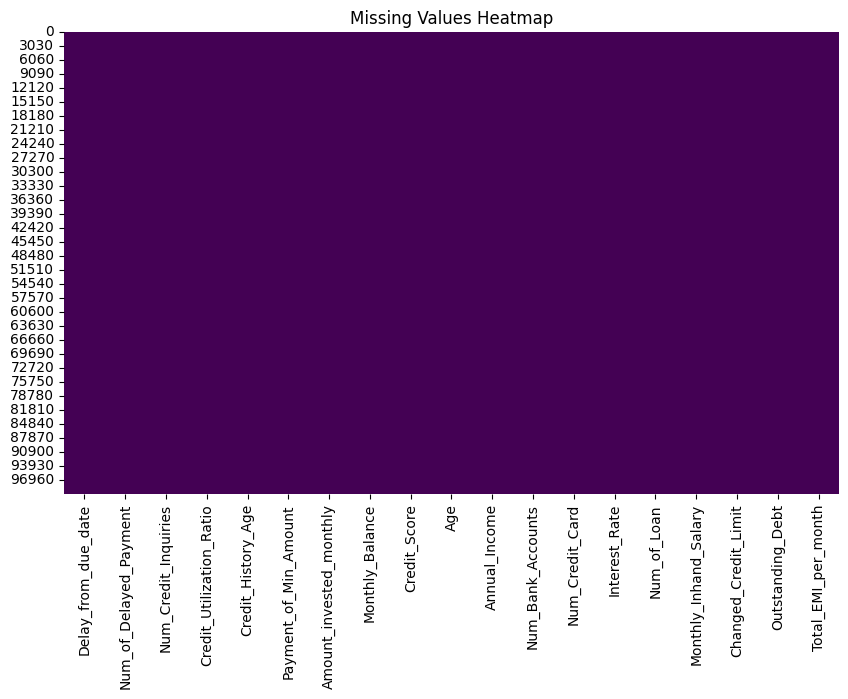

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))   # optional — makes the plot bigger
sb.heatmap(data.isnull(), cbar=False, cmap='viridis')  # use a color map for clarity
plt.title("Missing Values Heatmap")
plt.show()


### step:2) checking for duplicate records

In [8]:
data.duplicated(subset=data.columns).sum()

0

### step:3) selecting object or numeric field

In [9]:
cat_col = data.select_dtypes(include='object',exclude='number').columns.to_list()
cat_col

['Payment_of_Min_Amount', 'Credit_Score']

In [10]:
data[cat_col]['Payment_of_Min_Amount'].value_counts()

Payment_of_Min_Amount
Yes    52326
No     35628
NM     12006
Name: count, dtype: int64

### step:4 Converting the object column to numeric

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_col:
    data[col] = le.fit_transform(data[col])
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99960 entries, 0 to 99959
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Delay_from_due_date       99960 non-null  float64
 1   Num_of_Delayed_Payment    99960 non-null  float64
 2   Num_Credit_Inquiries      99960 non-null  float64
 3   Credit_Utilization_Ratio  99960 non-null  float64
 4   Credit_History_Age        99960 non-null  float64
 5   Payment_of_Min_Amount     99960 non-null  int32  
 6   Amount_invested_monthly   99960 non-null  float64
 7   Monthly_Balance           99960 non-null  float64
 8   Credit_Score              99960 non-null  int32  
 9   Age                       99960 non-null  float64
 10  Annual_Income             99960 non-null  float64
 11  Num_Bank_Accounts         99960 non-null  float64
 12  Num_Credit_Card           99960 non-null  float64
 13  Interest_Rate             99960 non-null  float64
 14  Num_of

<Axes: xlabel='Credit_Score'>

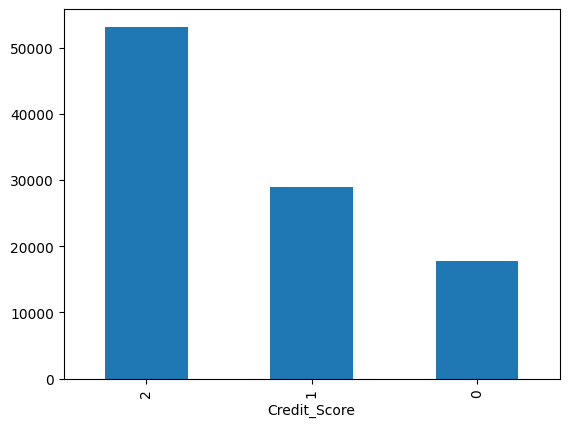

In [12]:
data['Credit_Score'].value_counts().plot(kind='bar')

In [13]:
#to show which integer Encoding represent which Value.
for i, cls in enumerate(le.classes_):
    print(f"{cls} → {i}")

Good → 0
Poor → 1
Standard → 2


### step:5) splitting the dataset into train test split

In [14]:
#selecting input and output variable.
x = data.drop(labels='Credit_Score',axis=1)
y = data['Credit_Score']

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

In [16]:
print("X_train shape:", x_train.shape)
print("X_test shape :", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

print("\nX_train data type (precision):", x_train.dtypes)
print("y_train data type (precision):", y_train.dtypes)

print("\nNumber of dimensions:")
print("X_train ndim:", x_train.ndim)
print("y_train ndim:", y_train.ndim)

X_train shape: (79968, 18)
X_test shape : (19992, 18)
y_train shape: (79968,)
y_test shape : (19992,)

X_train data type (precision): Delay_from_due_date         float64
Num_of_Delayed_Payment      float64
Num_Credit_Inquiries        float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount         int32
Amount_invested_monthly     float64
Monthly_Balance             float64
Age                         float64
Annual_Income               float64
Num_Bank_Accounts           float64
Num_Credit_Card             float64
Interest_Rate               float64
Num_of_Loan                 float64
Monthly_Inhand_Salary       float64
Changed_Credit_Limit        float64
Outstanding_Debt            float64
Total_EMI_per_month         float64
dtype: object
y_train data type (precision): int32

Number of dimensions:
X_train ndim: 2
y_train ndim: 1


### step:6) Now applying Inputs scaling to data

In [17]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss  = ss.transform(x_test)

In [18]:
print("\nX_train data type (precision):", x_train_ss.dtype)
print("y_train data type (precision):", y_train.dtypes)

print("\nNumber of dimensions:")
print("X_train ndim:", x_train_ss.ndim)
print("y_train ndim:", y_train.ndim)


X_train data type (precision): float64
y_train data type (precision): int32

Number of dimensions:
X_train ndim: 2
y_train ndim: 1


```
| Task Type                                | Input dtype     | Target dtype    | Loss Function          |
| ---------------------------------------- | --------------- | --------------- | ---------------------- |
| **Binary Classification (Sigmoid)**      | `torch.float32` | `torch.float32` | `nn.BCEWithLogitsLoss` |
| **Multi-class Classification (Softmax)** | `torch.float32` | `torch.long`    | `nn.CrossEntropyLoss`  |


```

### step:7) changing target variable dataframe object to numpy

In [19]:
import numpy as np
y_train_np = np.array(y_train,dtype=np.int64)
y_test_np  = np.array(y_test,dtype=np.int64)

### step:8) converting n umpy array object to tensor object

In [20]:
X_train_tensor = torch.tensor(x_train_ss, dtype=torch.float32)
X_test_tensor  = torch.tensor(x_test_ss, dtype=torch.float32)

# Convert target to long tensor (for classification)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test_np, dtype=torch.long)

In [21]:
# Check details
print("🔹 X_train_tensor Info:")
print("Type:", type(X_train_tensor))
print("Shape:", X_train_tensor.shape)
print("Dtype:", X_train_tensor.dtype)
print("Dimensions:", X_train_tensor.ndim)

print("\n🔹 y_train_tensor Info:")
print("Type:", type(y_train_tensor))
print("Shape:", y_train_tensor.shape)
print("Dtype:", y_train_tensor.dtype)
print("Dimensions:", y_train_tensor.ndim)

🔹 X_train_tensor Info:
Type: <class 'torch.Tensor'>
Shape: torch.Size([79968, 18])
Dtype: torch.float32
Dimensions: 2

🔹 y_train_tensor Info:
Type: <class 'torch.Tensor'>
Shape: torch.Size([79968])
Dtype: torch.int64
Dimensions: 1


### step:9) creating custom dataset class 

In [22]:
class CustomDataset(Dataset):
    #using constructor method to define the instance variable that can load the data
    def __init__(self,input,output):
        self.input = input
        self.output = output
        
    #using another magical method that show the shape of data
    def __len__(self):
        return len(self.input)
    
    #using another magical method that convert or load the data into batches.
    def __getitem__(self, index):
        return self.input[index],self.output[index]

In [23]:
# creating an object of custom dataset class.
train_dataset = CustomDataset(input=X_train_tensor,output=y_train_tensor)
test_dataset  = CustomDataset(input=X_test_tensor,output=y_test_tensor)

In [24]:
len(train_dataset),len(test_dataset)

(79968, 19992)

### step:10) using Dataloader class that load the data into batch_size

In [25]:
train_dataloader = DataLoader(dataset=train_dataset,batch_size=8,shuffle=True,pin_memory=True)
test_dataloader  = DataLoader(dataset=test_dataset,batch_size=8,shuffle=True,pin_memory=True)

In [26]:
import torch.nn.init as init

In [27]:
X_train_tensor.shape

torch.Size([79968, 18])

### step:11) defining custom neural network architecture class

In [28]:
class CustomNeuralNetworkArchitecture(nn.Module):
    #using constructor method defining neural architecture instance init.
    def __init__(self,input_feature,output_feature):
        
        #using super method to inherit the instance property from parent class
        super().__init__()
        
        #defining first hidden layer 
        #as we know that whatever nodes that we define in hidden & output that node will perform 2 operation.
        self.fc1 = nn.Linear(in_features=input_feature,out_features=128)
        #after performing linear mathematical operation now applying batch normalization.
        self.batchnorm1 = nn.BatchNorm1d(num_features=128,)
        
        #2nd operation will non linear operation decision maker known as Activation function
        self.relu1 = nn.ReLU()
        
        #to prevent the model from overfitting we used dropout layer
        self.dropout1 = nn.Dropout(p=0.3)
        
        
        #defining second hidden layer 
        #as we know that whatever nodes that we define in hidden & output that node will perform 2 operation.
        self.fc2 = nn.Linear(in_features=128,out_features=64)
        #after performing linear mathematical operation now applying batch normalization.
        self.batchnorm2 = nn.BatchNorm1d(num_features=64,)
        
        #2nd operation will non linear operation decision maker known as Activation function
        self.relu2 = nn.ReLU()
        
        #to prevent the model from overfitting we used dropout layer
        self.dropout2 = nn.Dropout(p=0.3)
        
        #defining Output layer 
        #as we know that in Output layer we dont apply any overfitting technique or batch normalization technique
        self.fc3 = nn.Linear(in_features=64,out_features=output_feature)
        

        #calling the init_weights_bias method
        self._init_weights_bias()
    
    #creating another method to initialize the weight and Bias(trainable parameter) by xavier/glorat technique
    def _init_weights_bias(self):
        #initalizing trainable parameter for first hidden layer of architecture ReLU → He Normal.
        init.kaiming_normal_(self.fc1.weight,nonlinearity='relu')
        init.zeros_(self.fc1.bias)
        
        
        #initalizing trainable parameter for second hidden layer of architecture ReLU → He Normal.
        init.kaiming_normal_(self.fc2.weight,nonlinearity='relu')
        init.zeros_(self.fc2.bias)
        
        #initalizing trainable parameter for Output layer of architecture Sigmoid → Xavier Uniform.
        init.xavier_uniform_(self.fc3.weight)
        init.zeros_(self.fc3.bias)
        
        
    #whenever we pass batch_size record to neural network architecture first algorithm will work is forward propogation algorithm
    def forward(self,input_batch_data):
        #first hidden layer
        x = self.fc1(input_batch_data)    #passing the batch input data to neural network 
        x = self.batchnorm1(x) #after getting linear out we do batch normalization so that variance will be comparable
        x = self.relu1(x)      #applying nonlinearity by Activation function
        x = self.dropout1(x)   #randomly selected node making deactivate at time of training
        
        #second hidden layer
        x = self.fc2(x)        #passing the batch input data to neural network 
        x = self.batchnorm2(x) #after getting linear out we do batch normalization so that variance will be comparable
        x = self.relu2(x)      #applying nonlinearity by Activation function
        x = self.dropout2(x)   #randomly selected node making deactivate at time of training
        
        
        #output layer
        x = self.fc3(x)        # softmax not applied here (CrossEntropyLoss will handle it)
        return x

In [29]:
#creating an object of CustomNeuralNetworkArchitecture class
input_feature = X_train_tensor.shape[1]
output = len(torch.unique(y_train_tensor))
model = CustomNeuralNetworkArchitecture(input_feature=input_feature,output_feature=output)
model

CustomNeuralNetworkArchitecture(
  (fc1): Linear(in_features=18, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

### if i want to show how many nos of trainable parameter need to be trained by model

In [30]:
from  torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
CustomNeuralNetworkArchitecture          --
├─Linear: 1-1                            2,432
├─BatchNorm1d: 1-2                       256
├─ReLU: 1-3                              --
├─Dropout: 1-4                           --
├─Linear: 1-5                            8,256
├─BatchNorm1d: 1-6                       128
├─ReLU: 1-7                              --
├─Dropout: 1-8                           --
├─Linear: 1-9                            195
Total params: 11,267
Trainable params: 11,267
Non-trainable params: 0

### step:13) doing hyperparameter tuning finding out the best or relevant parameter to improve the performance of model

In [31]:
import optuna

#### defining objective function passing first input as trials

In [32]:
class CustomNeuralNetworkArchitectureForHyperparameter(nn.Module):
    #using constructor method defining neural architecture instance init.
    def __init__(self,input_feature,output_feature,num_hidden_layer,neurons_per_hidden_layer,dropout_rate):
        
        #using super method to inherit the instance property from parent class
        super().__init__()
        
        #defining layer list object
        layers = []
        
        for i in range(num_hidden_layer):
            layers.append(nn.Linear(in_features=input_feature,out_features=neurons_per_hidden_layer))
            
            #batch normalization
            layers.append(nn.BatchNorm1d(num_features=neurons_per_hidden_layer))
            
            #activation function
            layers.append(nn.ReLU())
            
            
            # Dropout
            layers.append(nn.Dropout(p=dropout_rate))
            
            
            # updating input feature or dimension for the next layer
            input_feature = neurons_per_hidden_layer
        
        
        #finally connecting the output layers.
        layers.append(nn.Linear(in_features=input_feature,out_features=output_feature))
        
        
        # Combine all layers into a Sequential block
        self.model = nn.Sequential(*layers)
        
        
        #calling the weight initialization method.
        self._init_weights()
        
        
    # Weight initialization
    def _init_weights(self):
        for m in self.modules():
            # self.modules() returns all submodules (like fc1, fc2, fc3, etc.) from ANN architecture.
            if isinstance(m, nn.Linear):
                # ReLU ke liye He Initialization
                if m != list(self.modules())[-1]:  
                    # Agar ye last layer nahi hai (hidden layer hai)
                    init.kaiming_normal_(m.weight, nonlinearity='relu')
                else:
                    # Output layer ke liye Xavier Initialization
                    init.xavier_uniform_(m.weight)

                # Bias ko zero se initialize karna best practice hai
                init.zeros_(m.bias)
                
                
    #defining another method to do forward pass
    def forward(self,input_batch_data):
        x = self.model(input_batch_data)  # Sequential block handles all hidden layers
        return x  # logits, ready for CrossEntropyLoss

In [33]:
def objective(trial):
    # Defining the search space for Optuna (Incase ANN defining Hyperparmaeter like nos of hidden layer,neuron per layer..soon)
    #(Optuna uses a Bayesian optimization technique to efficiently explore the defined parameter space)
    num_hidden_layer = trial.suggest_int("num_hidden_layer", 1, 10)
    neurons_per_hidden_layer = trial.suggest_int("neurons_per_hidden_layer", 16, 512, step=16)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 10, 60,step=10)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    
    
    #defining the model and its all parameter
    input_feature = X_train_tensor.shape[1]
    output = len(torch.unique(y_train_tensor))
    
    #creating an object of CustomNeuralNetworkArchitectureForHyperparameter class
    model = CustomNeuralNetworkArchitectureForHyperparameter(
        input_feature=input_feature,
        output_feature=output,
        num_hidden_layer=num_hidden_layer,
        neurons_per_hidden_layer=neurons_per_hidden_layer,
        dropout_rate = dropout_rate
         
         ).to(device=device)
    
    
    #now initializing the remaining model parameter like epoch optimizer ...so on
    #target are multiclass classifier(&its integer encoded) so loss function sparse categorical cross entropy.
    loss_fxn = nn.CrossEntropyLoss()   #calculate loss value
    
    if optimizer_name == "Adam":
        #optimizers i am using Adam they will updates the trainable parameter effectively in each layer.
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr,weight_decay=weight_decay) 
    
    elif optimizer_name == "RMSprop":
        #optimizers i am using Adam they will updates the trainable parameter effectively in each layer.
        optimizer = torch.optim.RMSprop(params=model.parameters(),lr=lr,weight_decay=weight_decay) 
      
    
    elif optimizer_name == "SGD":
        #optimizers i am using Adam they will updates the trainable parameter effectively in each layer.
        optimizer = torch.optim.SGD(params=model.parameters(),lr=lr,weight_decay=weight_decay) 
    
    
    
    # EarlyStopping variables
    best_loss = np.inf         # abhi tak ka sabse best (minimum) test loss
    patience_counter = 0       # kitne epochs ho gaye bina improvement ke
    patience = 5               # agar 5 epoch tak test loss improve nahi hota to stop
    
    
    train_dataloader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
    test_dataloader  = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
    
    #Now training and evaluating the performance of model
    epochs = epochs
    training_loss_lst = []
    testing_loss_lst = []
    for i in range(epochs):
        #performing model training
        model.train()
        training_running_loss_count = 0
        
        #based on batchsize data record we are passing to neural network architecture.
        for feature,label in train_dataloader:
            feature = feature.to(device)
            label   = label.to(device)
            
            #whenever we start training the model first algorithm work is forward propogation
            pred_output = model.forward(feature)
            #print(f"actual output shape: {label.shape}")
            #print(f"predicted output shape: {pred_output.shape}")
            
            #calculating the loss value by using Loss fxns or evaluating the performance of model at time of training.
            loss_value = loss_fxn(pred_output,label)
            
            #now updating the training_running_loss_count variable
            training_running_loss_count = training_running_loss_count+loss_value.item() 
            #this item method we used to get value from shape of tensor
            
            #before applying backpropogation to the loss value first we have to clear the gradient inside optimizers
            optimizer.zero_grad()
            
            #reducing the loss value by using backpropogation algorithm and calcualting gradient of loss wrt to trainable parameter
            loss_value.backward()
            
            #using optimizers updating the tainable parameters
            optimizer.step()
            
        avg_training_loss = (training_running_loss_count)/(len(train_dataloader))
        training_loss_lst.append(avg_training_loss)

        
        #performing model testing(on testing we dont apply any backpropogation,overfitting technique,early stopping)
        model.eval()
        testing_running_loss_count = 0
        
        with torch.no_grad(): #at time of testing or inferencing gradient tracking is off not applying overfitting technique too
            #based on batchsize data record we are passing to neural network architecture.
            for feature,label in test_dataloader:
                feature = feature.to(device)
                label   = label.to(device)
                
                #whenever we start training the model first algorithm work is forward propogation
                pred_output = model.forward(feature)
                
                #calculating the loss value by using Loss fxns or evaluating the performance of model at time of training.
                loss_value = loss_fxn(pred_output,label)
                
                #updating the count of loss in testing_running_loss_count
                testing_running_loss_count = testing_running_loss_count+loss_value.item()
                
            avg_testing_loss = (testing_running_loss_count)/(len(test_dataloader))
            testing_loss_lst.append(avg_testing_loss)
                
        print(f"Epoch [{i+1}/{epochs}], "
            f"Train Loss: {avg_training_loss:.4f}, "
            f"Test Loss: {avg_testing_loss:.4f}, "
            )
        
        
        # ---------------- EARLY STOPPING + CHECKPOINT ----------------
        if avg_testing_loss < best_loss:
            # Agar test loss improve ho gaya hai
            best_loss = avg_testing_loss
            patience_counter = 0  # reset patience
            torch.save(model.state_dict(), "best_model_multi.pth")  # ModelCheckpoint
            print(f"✅ Model improved. Saved at epoch {i+1} with Test Loss {best_loss:.4f}")
            
        else:
            # Agar test loss improve nahi hua
            patience_counter += 1
            print(f"⚠️ No improvement. Patience counter = {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"⏹ Early stopping at epoch {i+1} (best loss = {best_loss:.4f})")
                break
            
    
    print("Training Finished ✅")   
    return best_loss  # <-- Very important for Optuna 
        


### Creating a study object

In [34]:
study = optuna.create_study(direction='minimize')
study

[I 2025-10-16 23:30:49,730] A new study created in memory with name: no-name-1e9f0b1d-32e7-40de-9197-87d844b98adf


In [ ]:
#now we will run the study object.
study.optimize(func=objective,n_trials=10)

Epoch [1/60], Train Loss: 1.2376, Test Loss: 1.0066, 
✅ Model improved. Saved at epoch 1 with Test Loss 1.0066
Epoch [2/60], Train Loss: 1.1864, Test Loss: 0.9950, 
✅ Model improved. Saved at epoch 2 with Test Loss 0.9950
Epoch [3/60], Train Loss: 1.1580, Test Loss: 0.9905, 
✅ Model improved. Saved at epoch 3 with Test Loss 0.9905
Epoch [4/60], Train Loss: 1.1388, Test Loss: 0.9796, 
✅ Model improved. Saved at epoch 4 with Test Loss 0.9796
Epoch [5/60], Train Loss: 1.1156, Test Loss: 0.9649, 
✅ Model improved. Saved at epoch 5 with Test Loss 0.9649
Epoch [6/60], Train Loss: 1.1011, Test Loss: 0.9619, 
✅ Model improved. Saved at epoch 6 with Test Loss 0.9619
Epoch [7/60], Train Loss: 1.0862, Test Loss: 0.9494, 
✅ Model improved. Saved at epoch 7 with Test Loss 0.9494
Epoch [8/60], Train Loss: 1.0750, Test Loss: 0.9443, 
✅ Model improved. Saved at epoch 8 with Test Loss 0.9443
Epoch [9/60], Train Loss: 1.0588, Test Loss: 0.9333, 
✅ Model improved. Saved at epoch 9 with Test Loss 0.9333
E

[I 2025-10-16 23:45:16,556] Trial 0 finished with value: 0.7995936025619507 and parameters: {'num_hidden_layer': 7, 'neurons_per_hidden_layer': 160, 'lr': 8.305660192212626e-05, 'weight_decay': 0.0006684433993811055, 'dropout_rate': 0.22347935224960988, 'batch_size': 32, 'epochs': 60, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.7995936025619507.


Epoch [60/60], Train Loss: 0.8709, Test Loss: 0.8000, 
⚠️ No improvement. Patience counter = 2/5
Training Finished ✅
Epoch [1/10], Train Loss: 0.8593, Test Loss: 0.7349, 
✅ Model improved. Saved at epoch 1 with Test Loss 0.7349
Epoch [2/10], Train Loss: 0.7865, Test Loss: 0.7155, 
✅ Model improved. Saved at epoch 2 with Test Loss 0.7155
Epoch [3/10], Train Loss: 0.7583, Test Loss: 0.7079, 
✅ Model improved. Saved at epoch 3 with Test Loss 0.7079
Epoch [4/10], Train Loss: 0.7438, Test Loss: 0.7003, 
✅ Model improved. Saved at epoch 4 with Test Loss 0.7003
Epoch [5/10], Train Loss: 0.7344, Test Loss: 0.7006, 
⚠️ No improvement. Patience counter = 1/5
Epoch [6/10], Train Loss: 0.7270, Test Loss: 0.6953, 
✅ Model improved. Saved at epoch 6 with Test Loss 0.6953
Epoch [7/10], Train Loss: 0.7217, Test Loss: 0.6922, 
✅ Model improved. Saved at epoch 7 with Test Loss 0.6922
Epoch [8/10], Train Loss: 0.7143, Test Loss: 0.6876, 
✅ Model improved. Saved at epoch 8 with Test Loss 0.6876
Epoch [9/1

[I 2025-10-16 23:47:09,807] Trial 1 finished with value: 0.6875817305088043 and parameters: {'num_hidden_layer': 7, 'neurons_per_hidden_layer': 432, 'lr': 7.237155970945903e-05, 'weight_decay': 0.0002339652612526213, 'dropout_rate': 0.11656900908614665, 'batch_size': 32, 'epochs': 10, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.6875817305088043.


Epoch [10/10], Train Loss: 0.7096, Test Loss: 0.6892, 
⚠️ No improvement. Patience counter = 2/5
Training Finished ✅
Epoch [1/20], Train Loss: 0.9712, Test Loss: 0.9434, 
✅ Model improved. Saved at epoch 1 with Test Loss 0.9434
Epoch [2/20], Train Loss: 0.8904, Test Loss: 0.8752, 
✅ Model improved. Saved at epoch 2 with Test Loss 0.8752
Epoch [3/20], Train Loss: 0.8735, Test Loss: 0.8533, 
✅ Model improved. Saved at epoch 3 with Test Loss 0.8533
Epoch [4/20], Train Loss: 0.8560, Test Loss: 0.8255, 
✅ Model improved. Saved at epoch 4 with Test Loss 0.8255
Epoch [5/20], Train Loss: 0.8443, Test Loss: 0.8113, 
✅ Model improved. Saved at epoch 5 with Test Loss 0.8113
Epoch [6/20], Train Loss: 0.8380, Test Loss: 0.7940, 
✅ Model improved. Saved at epoch 6 with Test Loss 0.7940
Epoch [7/20], Train Loss: 0.8342, Test Loss: 0.7909, 
✅ Model improved. Saved at epoch 7 with Test Loss 0.7909
Epoch [8/20], Train Loss: 0.8304, Test Loss: 0.7857, 
✅ Model improved. Saved at epoch 8 with Test Loss 0.

[I 2025-10-16 23:54:24,918] Trial 2 finished with value: 0.7587691581487656 and parameters: {'num_hidden_layer': 7, 'neurons_per_hidden_layer': 16, 'lr': 0.0004199864497763129, 'weight_decay': 0.0023183401076277547, 'dropout_rate': 0.2568209997687377, 'batch_size': 16, 'epochs': 20, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.6875817305088043.


Epoch [20/20], Train Loss: 0.8119, Test Loss: 0.7598, 
⚠️ No improvement. Patience counter = 3/5
Training Finished ✅
Epoch [1/20], Train Loss: 0.8673, Test Loss: 0.7318, 
✅ Model improved. Saved at epoch 1 with Test Loss 0.7318
Epoch [2/20], Train Loss: 0.7621, Test Loss: 0.7184, 
✅ Model improved. Saved at epoch 2 with Test Loss 0.7184
Epoch [3/20], Train Loss: 0.7417, Test Loss: 0.7093, 
✅ Model improved. Saved at epoch 3 with Test Loss 0.7093
Epoch [4/20], Train Loss: 0.7339, Test Loss: 0.7072, 
✅ Model improved. Saved at epoch 4 with Test Loss 0.7072
Epoch [5/20], Train Loss: 0.7263, Test Loss: 0.7060, 
✅ Model improved. Saved at epoch 5 with Test Loss 0.7060
Epoch [6/20], Train Loss: 0.7254, Test Loss: 0.7037, 
✅ Model improved. Saved at epoch 6 with Test Loss 0.7037
Epoch [7/20], Train Loss: 0.7244, Test Loss: 0.7008, 
✅ Model improved. Saved at epoch 7 with Test Loss 0.7008
Epoch [8/20], Train Loss: 0.7230, Test Loss: 0.7064, 
⚠️ No improvement. Patience counter = 1/5
Epoch [9/2

[I 2025-10-16 23:55:33,044] Trial 3 finished with value: 0.6962215304374695 and parameters: {'num_hidden_layer': 4, 'neurons_per_hidden_layer': 480, 'lr': 0.0005114538167198631, 'weight_decay': 0.0006685999531986146, 'dropout_rate': 0.4842381750699488, 'batch_size': 64, 'epochs': 20, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.6875817305088043.


Epoch [15/20], Train Loss: 0.7160, Test Loss: 0.6979, 
⚠️ No improvement. Patience counter = 5/5
⏹ Early stopping at epoch 15 (best loss = 0.6962)
Training Finished ✅
Epoch [1/60], Train Loss: 0.7627, Test Loss: 0.7155, 
✅ Model improved. Saved at epoch 1 with Test Loss 0.7155
Epoch [2/60], Train Loss: 0.7262, Test Loss: 0.7048, 
✅ Model improved. Saved at epoch 2 with Test Loss 0.7048
Epoch [3/60], Train Loss: 0.7158, Test Loss: 0.7054, 
⚠️ No improvement. Patience counter = 1/5
Epoch [4/60], Train Loss: 0.7099, Test Loss: 0.7015, 
✅ Model improved. Saved at epoch 4 with Test Loss 0.7015
Epoch [5/60], Train Loss: 0.7068, Test Loss: 0.6968, 
✅ Model improved. Saved at epoch 5 with Test Loss 0.6968
Epoch [6/60], Train Loss: 0.7045, Test Loss: 0.6945, 
✅ Model improved. Saved at epoch 6 with Test Loss 0.6945
Epoch [7/60], Train Loss: 0.7010, Test Loss: 0.6929, 
✅ Model improved. Saved at epoch 7 with Test Loss 0.6929
Epoch [8/60], Train Loss: 0.6999, Test Loss: 0.6982, 
⚠️ No improvement

[I 2025-10-16 23:58:21,089] Trial 4 finished with value: 0.6512440925779434 and parameters: {'num_hidden_layer': 2, 'neurons_per_hidden_layer': 400, 'lr': 0.0009829004029540628, 'weight_decay': 7.981003789131865e-05, 'dropout_rate': 0.174176319939639, 'batch_size': 64, 'epochs': 60, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.6512440925779434.


Epoch [52/60], Train Loss: 0.6570, Test Loss: 0.6550, 
⚠️ No improvement. Patience counter = 5/5
⏹ Early stopping at epoch 52 (best loss = 0.6512)
Training Finished ✅
Epoch [1/30], Train Loss: 0.8209, Test Loss: 0.7403, 
✅ Model improved. Saved at epoch 1 with Test Loss 0.7403
Epoch [2/30], Train Loss: 0.7719, Test Loss: 0.7249, 
✅ Model improved. Saved at epoch 2 with Test Loss 0.7249
Epoch [3/30], Train Loss: 0.7662, Test Loss: 0.7214, 
✅ Model improved. Saved at epoch 3 with Test Loss 0.7214
Epoch [4/30], Train Loss: 0.7640, Test Loss: 0.7211, 
✅ Model improved. Saved at epoch 4 with Test Loss 0.7211
Epoch [5/30], Train Loss: 0.7615, Test Loss: 0.7141, 
✅ Model improved. Saved at epoch 5 with Test Loss 0.7141
Epoch [6/30], Train Loss: 0.7598, Test Loss: 0.7235, 
⚠️ No improvement. Patience counter = 1/5
Epoch [7/30], Train Loss: 0.7580, Test Loss: 0.7184, 
⚠️ No improvement. Patience counter = 2/5
Epoch [8/30], Train Loss: 0.7581, Test Loss: 0.7146, 
⚠️ No improvement. Patience coun

[I 2025-10-17 00:03:48,909] Trial 5 finished with value: 0.711631095290184 and parameters: {'num_hidden_layer': 6, 'neurons_per_hidden_layer': 352, 'lr': 0.0009703425185676139, 'weight_decay': 0.0001905362513110782, 'dropout_rate': 0.3289793301656501, 'batch_size': 16, 'epochs': 30, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.6512440925779434.


Epoch [15/30], Train Loss: 0.7569, Test Loss: 0.7152, 
⚠️ No improvement. Patience counter = 5/5
⏹ Early stopping at epoch 15 (best loss = 0.7116)
Training Finished ✅
Epoch [1/20], Train Loss: 0.8132, Test Loss: 0.7552, 
✅ Model improved. Saved at epoch 1 with Test Loss 0.7552
Epoch [2/20], Train Loss: 0.7828, Test Loss: 0.7565, 
⚠️ No improvement. Patience counter = 1/5
Epoch [3/20], Train Loss: 0.7806, Test Loss: 0.7418, 
✅ Model improved. Saved at epoch 3 with Test Loss 0.7418
Epoch [4/20], Train Loss: 0.7819, Test Loss: 0.7493, 
⚠️ No improvement. Patience counter = 1/5
Epoch [5/20], Train Loss: 0.7816, Test Loss: 0.7409, 
✅ Model improved. Saved at epoch 5 with Test Loss 0.7409
Epoch [6/20], Train Loss: 0.7826, Test Loss: 0.7414, 
⚠️ No improvement. Patience counter = 1/5
Epoch [7/20], Train Loss: 0.7840, Test Loss: 0.7473, 
⚠️ No improvement. Patience counter = 2/5
Epoch [8/20], Train Loss: 0.7860, Test Loss: 0.7394, 
✅ Model improved. Saved at epoch 8 with Test Loss 0.7394
Epoch

[I 2025-10-17 00:05:25,520] Trial 6 finished with value: 0.7394327913610318 and parameters: {'num_hidden_layer': 9, 'neurons_per_hidden_layer': 352, 'lr': 0.0015030290486481484, 'weight_decay': 0.004272906634286534, 'dropout_rate': 0.4014622137892655, 'batch_size': 64, 'epochs': 20, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.6512440925779434.


Epoch [13/20], Train Loss: 0.7873, Test Loss: 0.7509, 
⚠️ No improvement. Patience counter = 5/5
⏹ Early stopping at epoch 13 (best loss = 0.7394)
Training Finished ✅
Epoch [1/30], Train Loss: 0.8058, Test Loss: 0.7316, 
✅ Model improved. Saved at epoch 1 with Test Loss 0.7316
Epoch [2/30], Train Loss: 0.7860, Test Loss: 0.7300, 
✅ Model improved. Saved at epoch 2 with Test Loss 0.7300
Epoch [3/30], Train Loss: 0.7864, Test Loss: 0.7312, 
⚠️ No improvement. Patience counter = 1/5
Epoch [4/30], Train Loss: 0.7864, Test Loss: 0.7335, 
⚠️ No improvement. Patience counter = 2/5
Epoch [5/30], Train Loss: 0.7839, Test Loss: 0.7332, 
⚠️ No improvement. Patience counter = 3/5
Epoch [6/30], Train Loss: 0.7838, Test Loss: 0.7361, 
⚠️ No improvement. Patience counter = 4/5


[I 2025-10-17 00:07:18,769] Trial 7 finished with value: 0.7300019882917405 and parameters: {'num_hidden_layer': 4, 'neurons_per_hidden_layer': 304, 'lr': 0.0051660410584279575, 'weight_decay': 7.072666905874787e-05, 'dropout_rate': 0.38778218888480487, 'batch_size': 16, 'epochs': 30, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.6512440925779434.


Epoch [7/30], Train Loss: 0.7833, Test Loss: 0.7320, 
⚠️ No improvement. Patience counter = 5/5
⏹ Early stopping at epoch 7 (best loss = 0.7300)
Training Finished ✅
Epoch [1/40], Train Loss: 0.9368, Test Loss: 0.7614, 
✅ Model improved. Saved at epoch 1 with Test Loss 0.7614
Epoch [2/40], Train Loss: 0.8065, Test Loss: 0.7468, 
✅ Model improved. Saved at epoch 2 with Test Loss 0.7468
Epoch [3/40], Train Loss: 0.7844, Test Loss: 0.7335, 
✅ Model improved. Saved at epoch 3 with Test Loss 0.7335
Epoch [4/40], Train Loss: 0.7696, Test Loss: 0.7255, 
✅ Model improved. Saved at epoch 4 with Test Loss 0.7255
Epoch [5/40], Train Loss: 0.7642, Test Loss: 0.7207, 
✅ Model improved. Saved at epoch 5 with Test Loss 0.7207
Epoch [6/40], Train Loss: 0.7630, Test Loss: 0.7222, 
⚠️ No improvement. Patience counter = 1/5
Epoch [7/40], Train Loss: 0.7592, Test Loss: 0.7116, 
✅ Model improved. Saved at epoch 7 with Test Loss 0.7116
Epoch [8/40], Train Loss: 0.7546, Test Loss: 0.7169, 
⚠️ No improvement. 